<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Построить модель для предсказания количества заказов такси в аэропорт на каждый час по историческим данным. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.index.is_monotonic

True

9     1373
11    1365
12    1317
10    1316
8     1253
      ... 
67       1
99       1
90       1
87       1
95       1
Name: num_orders, Length: 81, dtype: int64

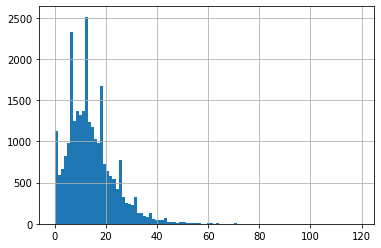

In [4]:
data['num_orders'].hist(bins=100)
data['num_orders'].value_counts()

Предварительные выводы поданным:
- даты в хронологическом порядке
- количество заказов не имеет пропусков и аномальных значений

## Анализ

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


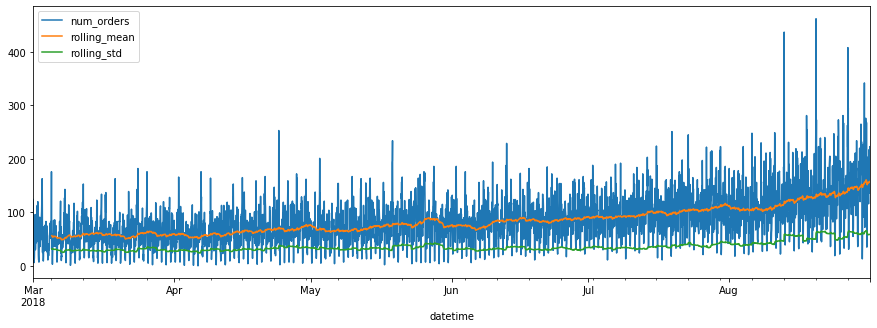

In [5]:
data = data.resample('1H').sum()
data['rolling_mean'] = data['num_orders'].rolling(100).mean()
data['rolling_std'] = data['num_orders'].rolling(100).std()
data.plot(figsize=(15, 5))
data = data.drop(['rolling_mean', 'rolling_std'], axis=1)
data.head()

1. Ряд не стационарный, так как меняется среднее
2. Наблюдается тренд: среднее значение растет

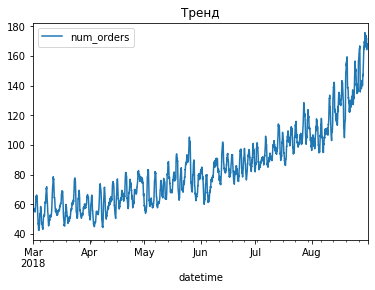

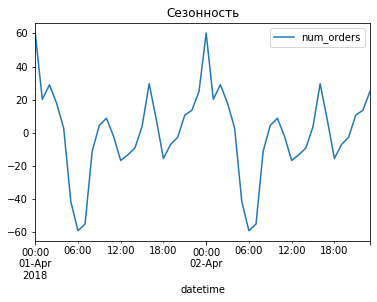

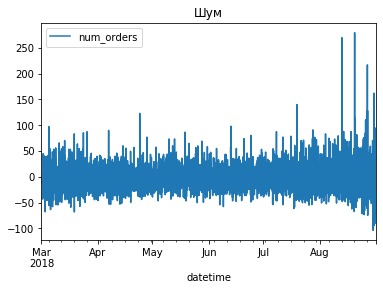

In [6]:
decomp = seasonal_decompose(data)
decomp.trend.plot(title='Тренд')
decomp.seasonal['2018-04-01':'2018-04-02'].plot(title='Сезонность')
decomp.resid.plot(title='Шум')

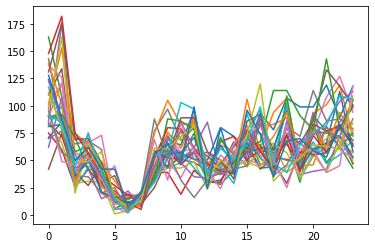

In [7]:
#По дню
for i in range(31):
    j = (i+1)*24
    plt.plot(data.iloc[i*24:j].reset_index(drop=True))

plt.show()

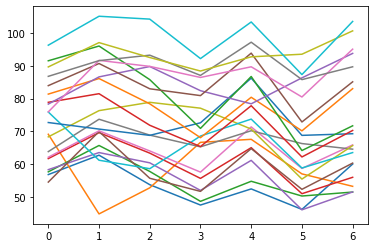

In [8]:
#По неделе
data_days = data.resample('1D').mean()
for i in range(20):
    j = (i+1)*7
    plt.plot(data_days['num_orders'].iloc[i*7:j].reset_index(drop=True))

plt.show()

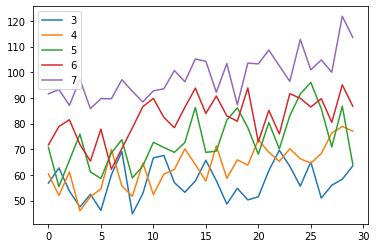

In [9]:
#По месяцу
leg = []
for i in range(5):
    j = (i+1)*30
    plt.plot(data_days['num_orders'].iloc[i*30:j].reset_index(drop=True))
    leg.append(i+3)

plt.legend(leg)
plt.show()

Сезонность в данных выявлена по времени суток: максимальная загруженность с 0 до 3 ночи, минимум примерно с 5 до 6 утра.


По дням недели - минимум заказов в субботу и четверг, максимум в пятницу и воскресенье.

По дням в месяце закономерности не выявлено.

## Обучение

Для начала требуется создать признаки. Потом разделить данные на выборки и выделить целевой признак

In [10]:
def features_maker(data, max_lag, rolling):
    
    new_data = data.copy()
    
    new_data['month'] = new_data.index.month
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    
    for i in range(1, max_lag + 1):
        new_data['lag_{}'.format(i)] = new_data['num_orders'].shift(i)
    
    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling).mean()
    
    return new_data

In [11]:
def separation(data):
    
    train, else_data = train_test_split(data, test_size=0.2, shuffle=False)
    valid, test = train_test_split(else_data, test_size=0.5, shuffle=False)
    train = train.dropna()
    
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train[['num_orders']]
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid[['num_orders']]
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test[['num_orders']]
    
    return features_train, target_train, features_valid, features_test, target_valid, target_test

Создание модели и поиск оптимальных параметром для создания признаков в данных

96 30.003263917149535


Text(0, 0.5, 'RMSE')

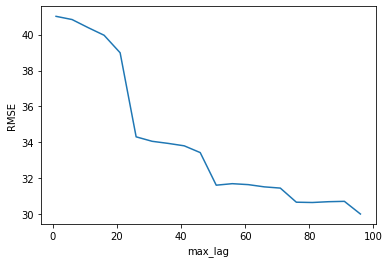

In [12]:
model = LinearRegression()
n_list = []
rmse_list = []
rmse_min = 100
for n in range(1, 100, 5):
    
#    data_feat = data.copy()
    data_feat = features_maker(data, n, 1)
    features_train, target_train, features_valid, features_test, target_valid, target_test = separation(data_feat)
    
    model.fit(features_train, target_train)
    rmse = np.sqrt(mean_squared_error(target_valid, model.predict(features_valid)))
    
    n_list.append(n)
    rmse_list.append(rmse)

    if rmse < rmse_min:
        rmse_min = rmse
        n_min = n
        
print(n_min, rmse_min)    
plt.plot(n_list, rmse_list)
plt.xlabel('max_lag')
plt.ylabel('RMSE')

Ошибка постоянно снижается с увеличением количества отстающих значений. Примерно после 50 она падает медленнее, целесообразно выбрать значение 50.

51 31.610893064742914


Text(0, 0.5, 'RMSE')

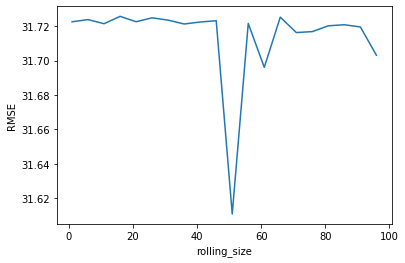

In [13]:
model = LinearRegression()
n_list = []
rmse_list = []
rmse_min = 100
for n in range(1, 100, 5):
    
    data_feat = data.copy()
    data_feat = features_maker(data_feat, 50, n)
    features_train, target_train, features_valid, features_test, target_valid, target_test = separation(data_feat)
    
    model.fit(features_train, target_train)
    rmse = np.sqrt(mean_squared_error(target_valid, model.predict(features_valid)))
    
    n_list.append(n)
    rmse_list.append(rmse)

    if rmse < rmse_min:
        rmse_min = rmse
        n_min = n
        
print(n_min, rmse_min)    
plt.plot(n_list, rmse_list)
plt.xlabel('rolling_size')
plt.ylabel('RMSE')

Минимум ошибки соответствует размеру окна скользящего среднего равному примерно 50

In [14]:
model_1 = LinearRegression()
data_feat = data.copy()
data_feat = features_maker(data_feat, 50, 50)
features_train, target_train, features_valid, features_test, target_valid, target_test = separation(data_feat)
    
model_1.fit(features_train, target_train)
rmse_lr = np.sqrt(mean_squared_error(target_valid, model_1.predict(features_valid)))
rmse_lr

31.72254878388476

In [15]:
#Масштабирование признаков
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)
features_train

array([[-1.41271345,  0.99859453, -1.37137836, ...,  0.31240523,
         1.40754105, -0.74477117],
       [-1.41271345,  0.99859453, -1.22694415, ..., -0.08088877,
         0.31215683, -0.87460921],
       [-1.41271345,  0.99859453, -1.08250994, ..., -0.22135091,
        -0.08105801, -0.90215061],
       ...,
       [ 1.48768055,  0.00399895, -1.51581257, ...,  2.5597995 ,
         0.14363619,  1.90969543],
       [ 1.48768055,  0.00399895, -1.37137836, ...,  2.11032064,
         2.55909882,  1.90182645],
       [ 1.48768055,  0.00399895, -1.22694415, ...,  0.76188408,
         2.10971042,  1.94379431]])

*StandardScaler при применении ко всей таблице выдает массив. Так можно оставить? И как заставить его выводить таблицу? Спасибо!*

In [16]:
model_1 = LinearRegression()
model_1.fit(features_train, target_train)
rmse_lr = np.sqrt(mean_squared_error(target_valid, model_1.predict(features_valid)))
rmse_lr

31.72200829710603

После масштабирования ошибка стала даже немного больше. То есть, в данном случае, масштабирование применять не стоит

Целесообразно оценить другие модели при данных параметрах: лес, дерево и градиентный бустинг

56 32.5894370540466


Text(0, 0.5, 'RMSE')

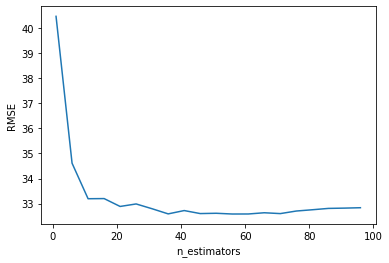

In [17]:
#Случайный лес
data_feat = data.copy()
data_feat = features_maker(data_feat, 50, 50)
features_train, target_train, features_valid, features_test, target_valid, target_test = separation(data_feat)

n_list = []
rmse_list = []
rmse_min = 100
for n in range(1, 100, 5):
    
    model = RandomForestRegressor(random_state=42, n_estimators=n, max_depth=10)
    model.fit(features_train, target_train)
    rmse = np.sqrt(mean_squared_error(target_valid, model.predict(features_valid)))
    
    n_list.append(n)
    rmse_list.append(rmse)

    if rmse < rmse_min:
        rmse_min = rmse
        n_min = n
        
print(n_min, rmse_min)    
plt.plot(n_list, rmse_list)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

15 32.24407040181561


Text(0, 0.5, 'RMSE')

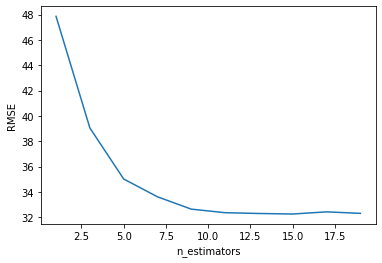

In [18]:
n_list = []
rmse_list = []
rmse_min = 100
for n in range(1, 20, 2):
    
    model = RandomForestRegressor(random_state=42, n_estimators=56, max_depth=n)
    model.fit(features_train, target_train)
    rmse = np.sqrt(mean_squared_error(target_valid, model.predict(features_valid)))
    n_list.append(n)
    rmse_list.append(rmse)

    if rmse < rmse_min:
        rmse_min = rmse
        n_min = n
        
print(n_min, rmse_min)            
plt.plot(n_list, rmse_list)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

Для случайного леса оптимальным сочетанием гиперпараметров является: глубина 15, количество деревьев 56

5 37.450232354206996


Text(0, 0.5, 'RMSE')

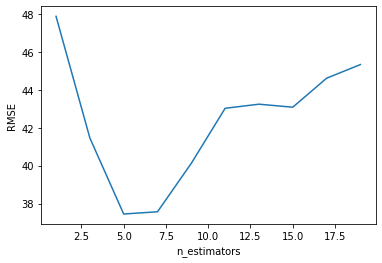

In [19]:
#Дерево

n_list = []
rmse_list = []
rmse_min = 100
for n in range(1, 20, 2):
    
    model = DecisionTreeRegressor(random_state=42, max_depth=n)
    model.fit(features_train, target_train)
    rmse = np.sqrt(mean_squared_error(target_valid, model.predict(features_valid)))
    
    n_list.append(n)
    rmse_list.append(rmse)

    if rmse < rmse_min:
        rmse_min = rmse
        n_min = n
        
print(n_min, rmse_min)    
plt.plot(n_list, rmse_list)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [20]:
model_4 = CatBoostRegressor(random_seed=42, loss_function='RMSE', iterations=300)
model_4.fit(features_train, target_train, verbose=50)
rmse_boost = np.sqrt(mean_squared_error(target_valid, model_4.predict(features_valid)))
rmse_boost

0:	learn: 35.1780207	total: 52.2ms	remaining: 15.6s
50:	learn: 23.3866324	total: 1.62s	remaining: 7.92s
100:	learn: 20.9724276	total: 3.21s	remaining: 6.32s
150:	learn: 19.8791860	total: 4.78s	remaining: 4.72s
200:	learn: 19.1138450	total: 6.46s	remaining: 3.18s
250:	learn: 18.4894478	total: 8.13s	remaining: 1.59s
299:	learn: 17.8702693	total: 10s	remaining: 0us


32.40486036409315

## Тестирование

In [21]:
model_1 = LinearRegression()
model_1.fit(features_train, target_train)
pred_1 = model_1.predict(features_test)
rmse_lr = np.sqrt(mean_squared_error(target_test, pred_1))
rmse_lr

43.01307033106149

In [22]:
model_2  = RandomForestRegressor(random_state=42, n_estimators=56, max_depth=15)
model_2.fit(features_train, target_train)
pred_2 = model_2.predict(features_test)
rmse_forest = np.sqrt(mean_squared_error(target_test, pred_2))
rmse_forest

47.6199654971744

In [23]:
model_3  = DecisionTreeRegressor(random_state=42, max_depth=5)
model_3.fit(features_train, target_train)
pred_3 = model_3.predict(features_test)
rmse_tree = np.sqrt(mean_squared_error(target_test, pred_3))
rmse_tree

56.14176803165107

In [24]:
model_4 = CatBoostRegressor(random_seed=42, loss_function='RMSE', iterations=300)
model_4.fit(features_train, target_train, verbose=50)
pred_4 = model_4.predict(features_test)
rmse_boost = np.sqrt(mean_squared_error(target_test, pred_4))
rmse_boost

0:	learn: 35.1780207	total: 3.97ms	remaining: 1.19s
50:	learn: 23.3866324	total: 1.77s	remaining: 8.64s
100:	learn: 20.9724276	total: 3.35s	remaining: 6.61s
150:	learn: 19.8791860	total: 4.93s	remaining: 4.86s
200:	learn: 19.1138450	total: 6.72s	remaining: 3.31s
250:	learn: 18.4894478	total: 8.29s	remaining: 1.62s
299:	learn: 17.8702693	total: 9.87s	remaining: 0us


51.995696608276404

In [25]:
median = pd.DataFrame(data=[target_train.median()]*len(target_test), index=target_test.index)
rmse_median = np.sqrt(mean_squared_error(target_test, median))
rmse_median

89.39768286346948

In [26]:
columns = ['Модель', 'RMSE']
name = ['Медиана', 'Линейная регрессия', 'Дерево', 'Случайный лес', 'Градиентный бустинг']
rmse = [rmse_median, rmse_lr, rmse_tree, rmse_forest, rmse_boost]
results = pd.DataFrame([name, rmse], columns)
display(results)

,0,1,2,3,4
Модель,Медиана,Линейная регрессия,Дерево,Случайный лес,Градиентный бустинг
RMSE,89.3977,43.0131,56.1418,47.62,51.9957


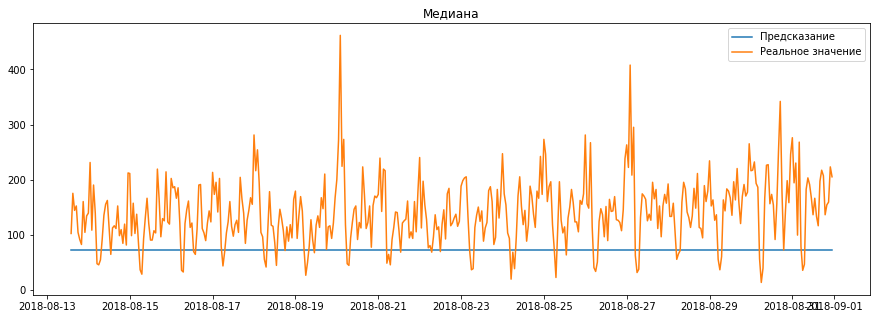

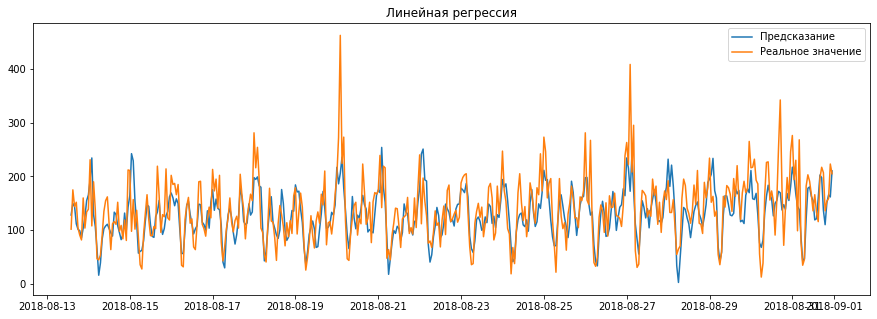

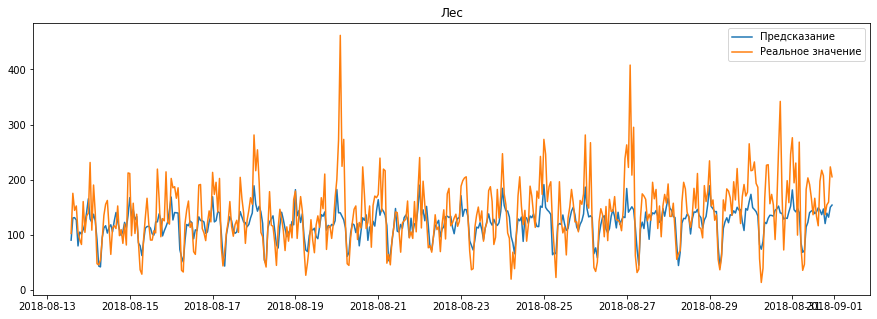

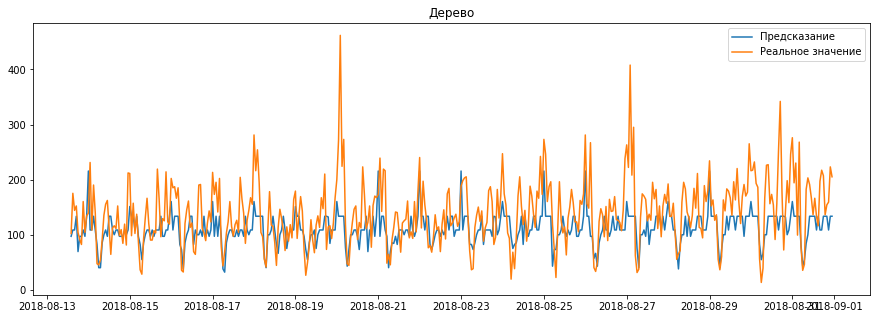

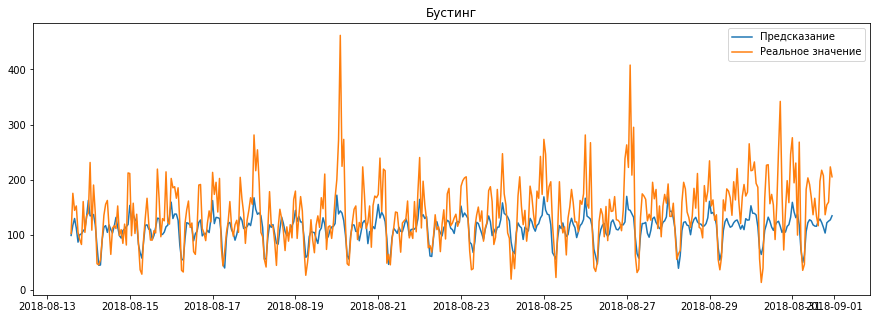

In [27]:
def graf(name, data): 
    plt.figure(figsize=(15, 5))
    plt.plot(data)
    plt.title(name)
    plt.plot(target_test)
    plt.legend(['Предсказание', 'Реальное значение'])
    plt.show()
    
graf('Медиана', median)
graf('Линейная регрессия', pd.DataFrame(data=pred_1, index=target_test.index))
graf('Лес', pd.DataFrame(data=pred_2, index=target_test.index))
graf('Дерево', pd.DataFrame(data=pred_3, index=target_test.index))
graf('Бустинг', pd.DataFrame(data=pred_4, index=target_test.index))

**Вывод**


В ходе данной работы были проанализированы данные о количестве заказов такси в аэропортах. На основе данных были построены модели, прогнозирующие количество заказов на следующий час.


В предоставленных данных были выявлены:
- тренд: количество заказов со временем увеличивается;
- сезонность в течение суток: наибольшое количество вызовов приходится на время с 0 до 3 часов ночи, минимум с 5 до 6 утра;
- сезонность по дням недели: наибольшое количество вызовов приходится на пятницу и воскресенье, а минимум на четверг и субботу.


Далее в данных были выделены признаки. На их основе были обучены модели: линейной регрессии, дерева, случайного леса и градиентного бустинга с различными параметрами с метрикой RMSE.


Далее оптимальные модели были проверены на тестовых данных, так же для проверки на адекватность было проведено сравнение с моделью, продсказывающей медиану по обучающей выборке. Лучшей моделью оказалась линейная регрессия, показавшая результат RMSE 43.